In [1]:
pip install coinmetrics-api-client

Note: you may need to restart the kernel to use updated packages.


In [1]:
from coinmetrics.api_client import CoinMetricsClient

client = CoinMetricsClient()

print(client)

In [36]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD  
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
# 
metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')

In [37]:
print(metrics)

In [42]:
import pandas as pd

metrics = pd.DataFrame(metrics)

metrics.head()

metrics.to_csv("coin_metrics.csv", index=False)

df = metrics.copy()


In [45]:
# Preparing for the data sets for training and testing

# Ensure datetime and sort
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

# Create lag features (previous day's metrics)
# df['PriceUSD_t-1'] = df['PriceUSD'].shift(1)
# df['TxTfrCnt_t-1'] = df['TxTfrCnt'].shift(1)
# df['AdrActCnt_t-1'] = df['AdrActCnt'].shift(1)
# df['HashRate_t-1'] = df['HashRate'].shift(1)
# df['SplyCur_t-1'] = df['SplyCur'].shift(1)


# Target: future price (e.g., 1-day ahead)
# df['PriceUSD_target'] = df['PriceUSD'].shift(-1)
df['PriceUSD_target'] = df['PriceUSD'].shift

# # Target: future price (e.g., 2-day ahead)
# df['PriceUSD_target'] = df['PriceUSD'].shift(-2)

# # Target: future price (e.g., 3-day ahead)
# df['PriceUSD_target'] = df['PriceUSD'].shift(-3)

# Gives the rolling mean and standard deviation for the last 3 days
# Rolling mean is the average value of the PriceUSD over the last 3 days
# Rolling std is the standard deviation of the PriceUSD over the last 3 days
# df['PriceUSD_roll_mean_3'] = df['PriceUSD'].rolling(window=3).mean()
# df['PriceUSD_roll_std_3'] = df['PriceUSD'].rolling(window=3).std()

df['day_of_week'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month

print(df.head())

# Drop missing values from lagging
df.dropna(inplace=True)

  asset                      time AdrActCnt          HashRate  \
0   btc 2013-01-01 00:00:00+00:00     38733   23.995203419462   
1   btc 2013-01-02 00:00:00+00:00     40911  22.6621365628253   
2   btc 2013-01-03 00:00:00+00:00     52539   23.995203419462   
3   btc 2013-01-04 00:00:00+00:00     46781  22.6621365628253   
4   btc 2013-01-05 00:00:00+00:00     53959  20.8847140873096   

           PriceUSD            SplyCur TxTfrCnt  day_of_week  month  \
0  13.3313714219755  10618089.91051183    73221            1      1   
1  13.2806068129749  10621914.90951183    83763            2      1   
2  13.3840811484512  10625964.90701183    89550            3      1   
3  13.4517211496201  10629789.90351183    96831            4      1   
4   13.459406766803  10633314.90101183    86261            5      1   

                                     PriceUSD_target  
0  <bound method NDFrame.shift of 0       13.3313...  
1  <bound method NDFrame.shift of 0       13.3313...  
2  <bound method 

In [46]:
# Splitting the data into training and testing sets

from sklearn.model_selection import train_test_split

X = df[['HashRate', 'TxTfrCnt', 'AdrActCnt', 'SplyCur', 'day_of_week', 'month']]
y = df['PriceUSD_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


X_train shape: (3647, 19), y_train shape: (3647,)
Best parameters: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 100}
X_test shape: (1, 19)
Test set MAE: 0.47
df_all_results shape before saving: (3648, 4)
df_all_results first few rows:                        time  actual_price_usd  predicted_price_usd dataset
3 2013-01-04 00:00:00+00:00  13.5560616578025            13.841176   train
4 2013-01-05 00:00:00+00:00  13.7803506312098            14.065239   train
5 2013-01-06 00:00:00+00:00  13.8209552565751            14.105695   train
6 2013-01-07 00:00:00+00:00    14.12317285564            14.407971   train
7 2013-01-08 00:00:00+00:00  14.2276211227352            14.512268   train
Complete results file saved successfully
Test predictions file saved successfully


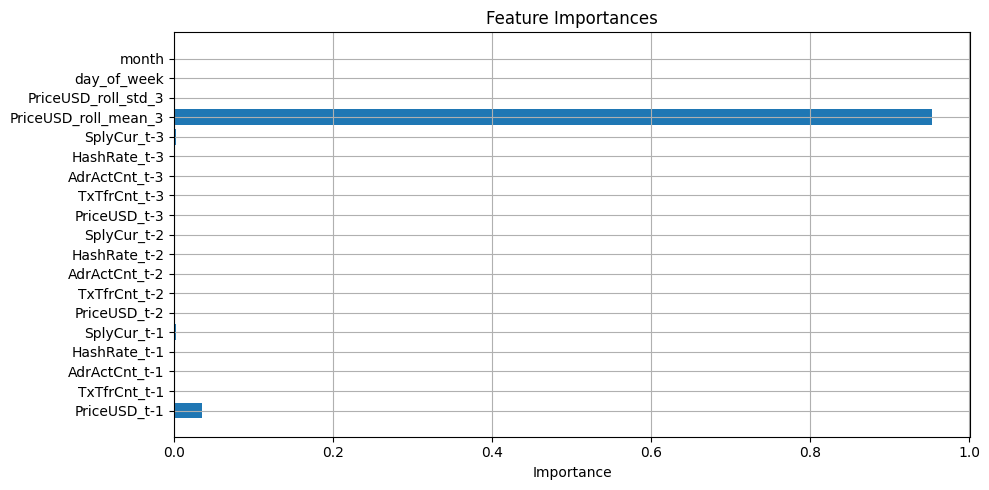

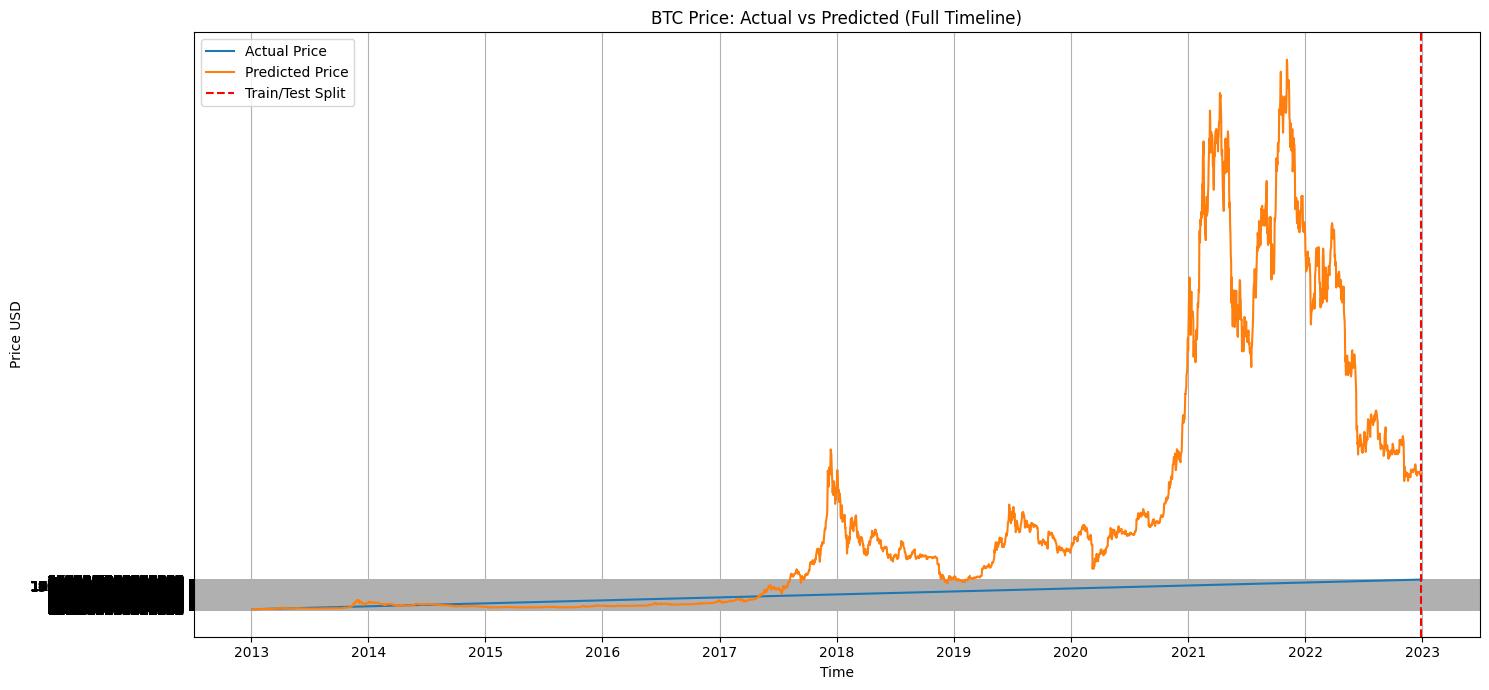

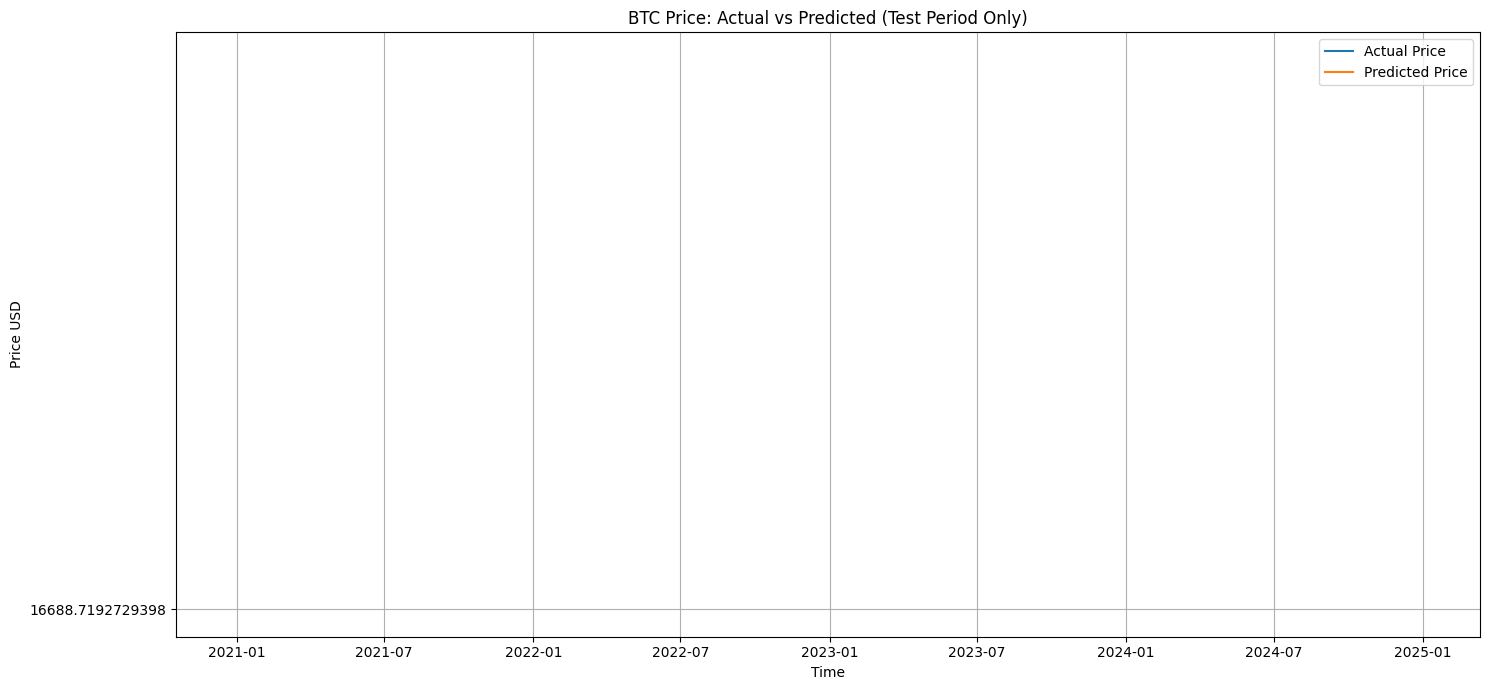

Training MAE: 0.42
Test MAE: 0.47


TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [ ]:
# Training the model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Fix TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Parameter grid
# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

best_params = gridSearch.best_params_

# GRID SEARCH USING GRADIENT BOOSTING REGRESSOR
# grid_search_model = GridSearchCV(
#     GradientBoostingRegressor(random_state=42),
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='neg_mean_absolute_error',
#     n_jobs=6
# )
grid_search_model = GradientBoostingRegressor(
    n_estimators=best_params.get('n_estimators', 100),
    max_depth=best_params.get('max_depth', 30),
    min_samples_split=best_params.get('min_samples_split', 10),
    random_state=42
)

grid_search_model.fit(X_train, y_train)

# Create predictions for ALL dates in your dataset
# First for training data (to see how well the model fits)
y_train_pred = model.predict(X_train)

# Then for test data (to evaluate out-of-sample performance)
y_test_pred = model.predict(X_test)

# Add debug output
# print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)

# Final Model - Use the best parameters from grid search
# best_params = grid_search.best_params_
# model = GradientBoostingRegressor(
#     n_estimators=best_params.get('n_estimators', 100),
#     max_depth=best_params.get('max_depth', 30),
#     min_samples_split=best_params.get('min_samples_split', 10),
#     random_state=42
# )
# model.fit(X_train, y_train)

# # Debug output before prediction
# print(f"X_test shape: {X_test.shape}")

# # # Predict
# # y_pred = model.predict(X_test)

# # Create separate DataFrames for train and test predictions
# df_train_result = pd.DataFrame({
#     'time': df.loc[y_train.index, 'time'] if 'time' in df.columns else pd.Series(y_train.index),
#     'actual_price_usd': y_train.values,
#     'predicted_price_usd': y_train_pred,
#     'dataset': 'train'
# })

# df_test_result = pd.DataFrame({
#     'time': df.loc[y_test.index, 'time'] if 'time' in df.columns else pd.Series(y_test.index),
#     'actual_price_usd': y_test.values,
#     'predicted_price_usd': y_test_pred,
#     'dataset': 'test'
# })


# # Combine into one DataFrame with all predictions
# df_all_results = pd.concat([df_train_result, df_test_result])

# # Sort by time if you have a time column, otherwise by index
# if 'time' in df_all_results.columns:
#     df_all_results = df_all_results.sort_values('time')
# else:
#     df_all_results = df_all_results.sort_index()

# # Save to CSV
# df_all_results.to_csv("btc_price_actual_vs_predicted_all.csv", index=False)
# print(f"Complete results saved. Shape: {df_all_results.shape}")

# # You can also visualize both training and test predictions
# plt.figure(figsize=(15, 7))
# plt.plot(df_all_results['time'], df_all_results['actual_price_usd'], label='Actual Price')
# plt.plot(df_all_results['time'], df_all_results['predicted_price_usd'], label='Predicted Price')
# plt.axvline(x=df_train_result['time'].max(), color='r', linestyle='--', label='Train/Test Split')
# plt.title('BTC Price: Actual vs Predicted (Full Timeline)')
# plt.xlabel('Time')
# plt.ylabel('Price USD')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Evaluate
# mae = mean_absolute_error(y_test, y_pred)
# print(f"MAE: {mae:.2f}")

# # # Check if test indices exist in the original DataFrame
# # print(f"Test indices in df: {all(idx in df.index for idx in y_test.index)}")

# # # Debug original dataframe
# # print(f"Original df shape: {df.shape}")
# # print(f"Original df columns: {df.columns}")

# # # Save predictions to DataFrame
# # df_result = pd.DataFrame({
# #     'time': df.loc[y_test.index, 'time'] if 'time' in df.columns else pd.Series(y_test.index),
# #     'actual_price_usd': y_test.values,
# #     'predicted_price_usd': y_pred
# # })

# # # Save to CSV with debug
# # print(f"df_result shape before saving: {df_result.shape}")
# # print(f"df_result first few rows: {df_result.head()}")
# # df_result.to_csv("btc_price_actual_vs_predicted.csv", index=False)
# # print("File saved successfully")

# # # Plot feature importances
# # feature_names = X_train.columns
# # importances = model.feature_importances_
# # plt.figure(figsize=(10, 5))
# # plt.barh(feature_names, importances)
# # plt.title("Feature Importances")
# # plt.xlabel("Importance")
# # plt.grid(True)
# # plt.tight_layout()
# # plt.show()

# Training the model




In [15]:
# PART 1: Set up future prediction parameters
# -----------------------------------------
future_days = 30  # Adjust as needed - how many days into the future you want to predict

# Display the last few rows of your training data to understand what we're continuing from
print("Last 5 rows of the existing dataset:")
display(df.tail())  # Jupyter display command for nicer output


Last 5 rows of the existing dataset:


,asset,time,AdrActCnt,HashRate,PriceUSD,SplyCur,TxTfrCnt,PriceUSD_t-1,TxTfrCnt_t-1,AdrActCnt_t-1,...,PriceUSD_t-3,TxTfrCnt_t-3,AdrActCnt_t-3,HashRate_t-3,SplyCur_t-3,PriceUSD_target,PriceUSD_roll_mean_3,PriceUSD_roll_std_3,day_of_week,month
3646,btc,2022-12-26 00:00:00+00:00,787672,226776484.5495916524977316888674357787936,16879.9382273524,19243872.84912565,662792,16824.8389736996,602458,731599,...,16780.5169798363,838234,891725,232050357.9905657561936134814135442212064,19241629.1664071,16630.5931551724,16847.463124,28.840300,0,12
3647,btc,2022-12-27 00:00:00+00:00,867369,202165083.5965739739198448628034385929312,16698.9112708942,19244591.56963517,707594,16879.9382273524,662792,787672,...,16837.612170076,672129,758680,156458196.4740352053610362517910656282752,19242185.39006796,16593.6888287551,16801.229491,92.794103,1,12
3648,btc,2022-12-28 00:00:00+00:00,904203,295336819.0305874677372472980040242212064,16536.2942001753,19245641.52108695,786787,16698.9112708942,707594,867369,...,16824.8389736996,602458,731599,247871973.2505711840795219355611642212064,19243066.62385341,16524.2178024547,16705.047899,171.904183,2,12
3649,btc,2022-12-29 00:00:00+00:00,945186,247871973.2505711840795219355611642212064,16630.5931551724,19246522.72788417,802781,16536.2942001753,786787,904203,...,16879.9382273524,662792,787672,226776484.5495916524977316888674357787936,19243872.84912565,16606.7520432496,16621.932875,81.653709,3,12
3650,btc,2022-12-30 00:00:00+00:00,1050756,277757245.1131045247524220924259171858624,16593.6888287551,19247510.18309141,881174,16630.5931551724,802781,945186,...,16698.9112708942,707594,867369,202165083.5965739739198448628034385929312,19244591.56963517,16688.7192729398,16586.858728,47.519059,4,12


In [16]:
# PART 2: Create future dates
# --------------------------
# Determine the format of your dates/timestamps
if isinstance(df.index, pd.DatetimeIndex):
    # Using DatetimeIndex
    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(future_days)]
    date_format = "DatetimeIndex"
elif 'time' in df.columns:
    if isinstance(df['time'].iloc[-1], str):
        # String dates - try to parse
        last_date = datetime.strptime(df['time'].iloc[-1], '%Y-%m-%d')  # Adjust format as needed
        future_dates = [last_date + timedelta(days=i+1) for i in range(future_days)]
        date_format = "String dates"
    else:
        # Assuming timestamp objects or similar
        last_date = df['time'].iloc[-1]
        future_dates = [last_date + timedelta(days=i+1) for i in range(future_days)]
        date_format = "Timestamp objects"
else:
    # Using numeric indices
    last_date = df.index[-1]
    future_dates = [last_date + i + 1 for i in range(future_days)]
    date_format = "Numeric indices"

print(f"Using {date_format} format")
print(f"Last date in dataset: {last_date}")
print(f"First future date: {future_dates[0]}")
print(f"Last future date: {future_dates[-1]}")

Using Timestamp objects format
Last date in dataset: 2022-12-30 00:00:00+00:00
First future date: 2022-12-31 00:00:00+00:00
Last future date: 2023-01-29 00:00:00+00:00


In [17]:
# PART 3: Create a dataframe to hold the future feature data
# ---------------------------------------------------------
future_features = pd.DataFrame(index=future_dates)
if 'time' in df.columns:
    future_features['time'] = future_dates



Features that will be needed for prediction:
  - PriceUSD_t-1
  - TxTfrCnt_t-1
  - AdrActCnt_t-1
  - HashRate_t-1
  - SplyCur_t-1
  - PriceUSD_t-2
  - TxTfrCnt_t-2
  - AdrActCnt_t-2
  - HashRate_t-2
  - SplyCur_t-2
  - PriceUSD_t-3
  - TxTfrCnt_t-3
  - AdrActCnt_t-3
  - HashRate_t-3
  - SplyCur_t-3
  - PriceUSD_roll_mean_3
  - PriceUSD_roll_std_3
  - day_of_week
  - month

Using 30 recent price points for feature generation


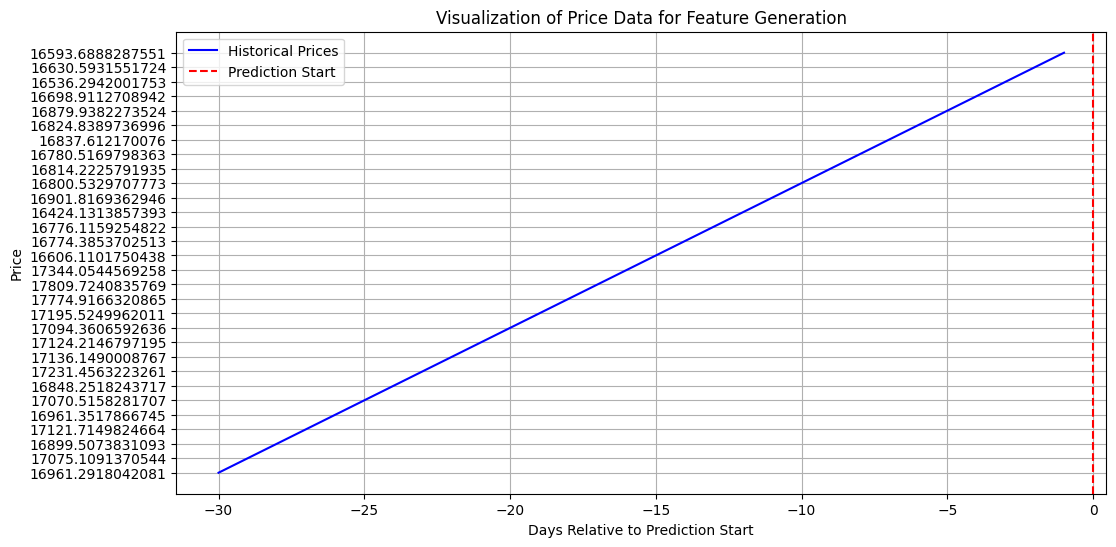

In [22]:
# PART 4: Generate feature values for future prediction
# ----------------------------------------------------
# Get the feature names from your training data
print("\nFeatures that will be needed for prediction:")
for feature in X_train.columns:
    print(f"  - {feature}")

# Get recent price history to use for feature creation
latest_prices = list(df['PriceUSD'].iloc[-30:])  # Adjust column name and window size as needed
print(f"\nUsing {len(latest_prices)} recent price points for feature generation")

# Initialize the list to store future prices
future_prices = []

# Create a cell to show visualization of feature generation process
plt.figure(figsize=(12, 6))
plt.plot(range(-len(latest_prices), 0), latest_prices, 'b-', label='Historical Prices')
plt.axvline(x=0, color='r', linestyle='--', label='Prediction Start')
plt.xlabel('Days Relative to Prediction Start')
plt.ylabel('Price')
plt.title('Visualization of Price Data for Feature Generation')
plt.legend()
plt.grid(True)

In [23]:
# PART 5: Generate predictions one day at a time
# ---------------------------------------------
print("\nGenerating future predictions day by day:")
for future_idx, future_date in enumerate(future_dates):
    # Create a progress message
    print(f"Predicting for day {future_idx+1}/{future_days}: {future_date}")
    
    # Add feature columns to match X_train
    for feature_name in X_train.columns:
        # Here you need to implement logic for each type of feature
        # This is very specific to your feature set - below are examples
        
        # Example 1: Lag features (previous days' prices)
        if 'lag' in feature_name:
            lag_days = int(feature_name.split('_')[1])
            if future_idx < lag_days:
                # Use actual historical data when available
                position = len(latest_prices) - lag_days + future_idx
                future_features.loc[future_date, feature_name] = latest_prices[position]
            else:
                # Use previously predicted values
                predicted_idx = future_idx - lag_days
                future_features.loc[future_date, feature_name] = future_prices[predicted_idx]
                
        # Example 2: Rolling window features (moving averages, etc.)
        elif 'rolling' in feature_name:
            window = int(feature_name.split('_')[-1])
            if future_idx == 0:
                # First prediction: use mostly historical data
                values = latest_prices[-window+1:] + [0]  # Placeholder for unknown value
                future_features.loc[future_date, feature_name] = sum(values) / len(values)
            else:
                # Later predictions: use combination of historical and predicted values
                available_history = min(window-1, len(latest_prices))
                values = (
                    latest_prices[-available_history:] + 
                    future_prices[:min(future_idx, window-available_history)]
                )
                future_features.loc[future_date, feature_name] = sum(values) / len(values)
                
        # Example 3: Calendar features
        elif feature_name == 'day_of_week' and isinstance(future_date, (datetime, pd.Timestamp)):
            future_features.loc[future_date, feature_name] = future_date.dayofweek
        elif feature_name == 'month' and isinstance(future_date, (datetime, pd.Timestamp)):
            future_features.loc[future_date, feature_name] = future_date.month
        elif feature_name == 'day' and isinstance(future_date, (datetime, pd.Timestamp)):
            future_features.loc[future_date, feature_name] = future_date.day
            
        # Example 4: Other features - might need domain-specific logic
        else:
            # Default approach: use the last known value from the dataset
            if feature_name in df.columns:
                future_features.loc[future_date, feature_name] = df[feature_name].iloc[-1]
            else:
                # Feature might be derived - set to zero or another reasonable default
                future_features.loc[future_date, feature_name] = 0
                print(f"Warning: Feature '{feature_name}' not found in dataset, using default value 0")

    # Verify that we have populated all required features
    missing_features = [f for f in X_train.columns if f not in future_features.columns]
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        for f in missing_features:
            future_features[f] = 0  # Add with default value
    
    # Make prediction for this future date
    try:
        X_future = future_features.loc[[future_date], X_train.columns]
        future_price = model.predict(X_future)[0]
        
        # Store the predicted price
        future_prices.append(future_price)
        
        # Add the predicted price to the future_features DataFrame
        future_features.loc[future_date, 'predicted_price_usd'] = future_price
        
        print(f"  → Predicted price: ${future_price:.2f}")
    except Exception as e:
        print(f"Error making prediction: {e}")
        print(f"Feature data: {X_future.head()}")
        break



Generating future predictions day by day:
Predicting for day 1/30: 2022-12-31 00:00:00+00:00
  → Predicted price: $16687.42
Predicting for day 2/30: 2023-01-01 00:00:00+00:00
  → Predicted price: $16708.97
Predicting for day 3/30: 2023-01-02 00:00:00+00:00
  → Predicted price: $16711.81
Predicting for day 4/30: 2023-01-03 00:00:00+00:00
  → Predicted price: $16711.81
Predicting for day 5/30: 2023-01-04 00:00:00+00:00
  → Predicted price: $16709.18
Predicting for day 6/30: 2023-01-05 00:00:00+00:00
  → Predicted price: $16709.21
Predicting for day 7/30: 2023-01-06 00:00:00+00:00
  → Predicted price: $16709.55
Predicting for day 8/30: 2023-01-07 00:00:00+00:00
  → Predicted price: $16707.78
Predicting for day 9/30: 2023-01-08 00:00:00+00:00
  → Predicted price: $16708.97
Predicting for day 10/30: 2023-01-09 00:00:00+00:00
  → Predicted price: $16711.81
Predicting for day 11/30: 2023-01-10 00:00:00+00:00
  → Predicted price: $16711.81
Predicting for day 12/30: 2023-01-11 00:00:00+00:00
 

In [25]:

# PART 6: Create final output DataFrame and display
# ------------------------------------------------
if len(future_prices) > 0:
    future_output = pd.DataFrame({
        'time': future_dates[:len(future_prices)],
        'predicted_price_usd': future_prices
    })
    
    print("\nFuture predictions:")
    display(future_output)
    
    # Save future predictions to CSV
    future_output.to_csv("btc_future_price_predictions.csv", index=False)
    print(f"Future predictions saved to btc_future_price_predictions.csv")
    
    


Future predictions:


,time,predicted_price_usd
0,2022-12-31 00:00:00+00:00,16687.418698
1,2023-01-01 00:00:00+00:00,16708.972737
2,2023-01-02 00:00:00+00:00,16711.809868
3,2023-01-03 00:00:00+00:00,16711.809868
4,2023-01-04 00:00:00+00:00,16709.184909
5,2023-01-05 00:00:00+00:00,16709.212530
6,2023-01-06 00:00:00+00:00,16709.549876
7,2023-01-07 00:00:00+00:00,16707.779989
8,2023-01-08 00:00:00+00:00,16708.972737
9,2023-01-09 00:00:00+00:00,16711.809868


Future predictions saved to btc_future_price_predictions.csv


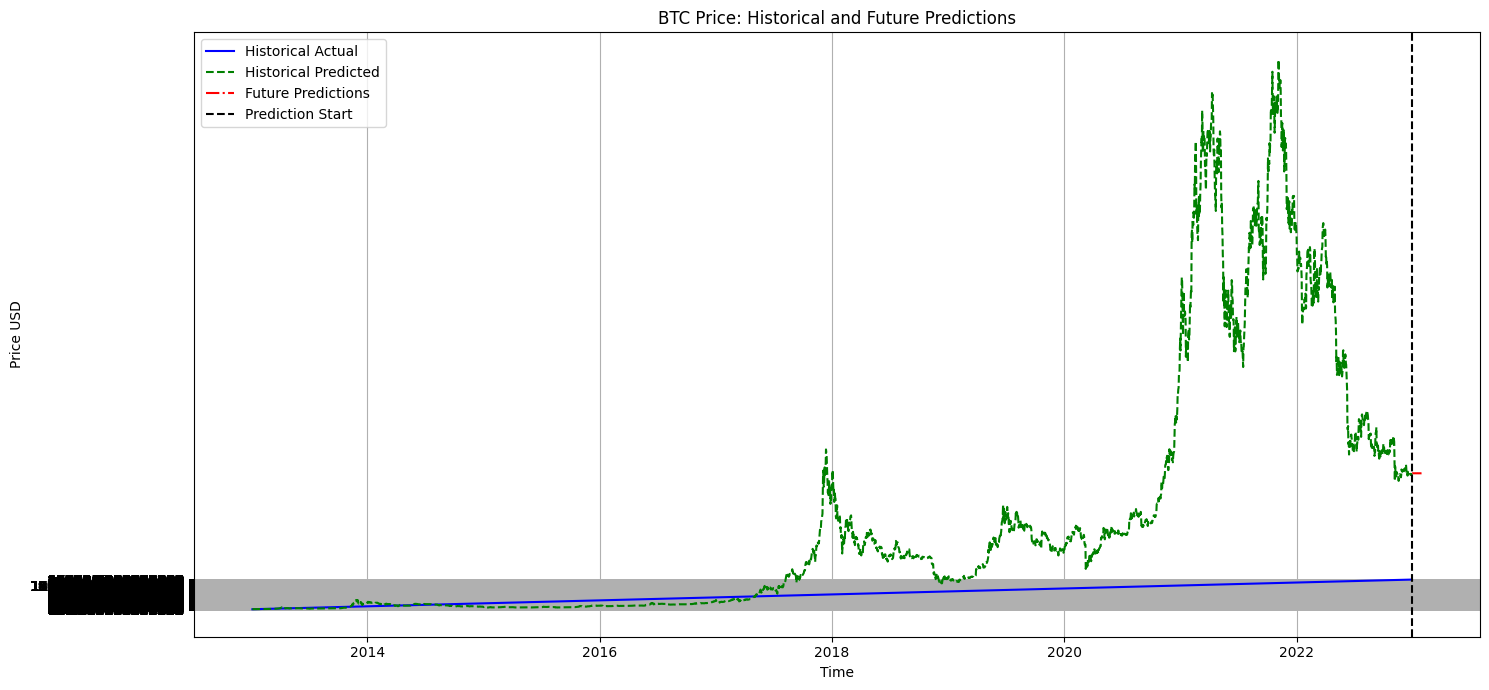


Future prediction complete!


In [30]:
# PART 7: Visualize historical + future predictions
    # ------------------------------------------------
plt.figure(figsize=(15, 7))
    
    # Historical actual prices
historical_dates = df['time'] if 'time' in df.columns else df.index
historical_prices = df['PriceUSD']  # Adjust column name if different
plt.plot(historical_dates, historical_prices, 
label='Historical Actual', color='blue')
    
    # Historical predictions (if available)
if 'df_all_results' in globals():
    plt.plot(df_all_results['time'], df_all_results['predicted_price_usd'], 
             label='Historical Predicted', color='green', linestyle='--')
    
    # Future predictions
    plt.plot(future_output['time'], future_output['predicted_price_usd'], 
             label='Future Predictions', color='red', linestyle='-.')
    
    # Add vertical line separating historical and future data
    plt.axvline(x=last_date, color='black', linestyle='--', label='Prediction Start')
    
    plt.title('BTC Price: Historical and Future Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price USD')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("full_prediction_timeline.png")
    plt.show()
    
    print("\nFuture prediction complete!")
else:
    print("\nNo future predictions were generated due to errors.")